In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

In [2]:
# Base modules
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Keras modules
from keras import models
from keras import layers
from keras import optimizers

Base implementation is taken from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb 

## Prepare dataset

### 1.1 Load CIFAR-10 dataset

In [3]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

num_classes = 10

In [4]:
# The data, shuffled and split between train and test sets:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()
print('x_train shape:', x_train_orig.shape)

# Split train sets into train and valid sets
x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x_train_orig, y_train_orig, test_size=0.1)

print(x_train_orig.shape[0], 'train samples')
print(x_valid_orig.shape[0], 'valid samples')
print(x_test_orig.shape[0], 'test samples')

# Convert class vectors to binary class matrices (a.k.a one hot encoding)
y_train_one_hot = keras.utils.to_categorical(y_train_orig, num_classes)
y_valid_one_hot = keras.utils.to_categorical(y_valid_orig, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test_orig, num_classes)

x_train shape: (50000, 32, 32, 3)
45000 train samples
5000 valid samples
10000 test samples


### 1.2 Check balance of the Dataset 

In [5]:
def check_balance(dataset_labels, dataset_name, num_classes):
    items_per_classes = []

    for c in range(num_classes):
        items_per_classes.append(len(dataset_labels[dataset_labels == c]))

    plt.figure()
    plt.bar(np.arange(num_classes), items_per_classes)
    max_items_per_classes = max(items_per_classes)
    plt.axis([0, num_classes, 0, 1.1 * max_items_per_classes])
    plt.title("Number of samples for each class for " + dataset_name + '. Total #: ' + str(np.sum(items_per_classes, axis=0)))
    plt.grid(True)

In [28]:
# # we expect the data to be balanced across classes.
# check_balance(y_train_orig, 'train_dataset', num_classes)
# check_balance(y_valid_orig, 'valid_dataset', num_classes)
# check_balance(y_test_orig, 'valid_dataset', num_classes)

### 1.3. Define methods for plotting accuracy and loss curves

In [6]:
def plot_history_curve(plt_col, train_values, valid_values, title, ylabel, xlabel):
    plt_col.plot(train_values)
    plt_col.plot(valid_values)
    plt_col.set_title(title)
    plt_col.set_ylabel(ylabel)
    plt_col.set_xlabel(xlabel)
    plt_col.legend(['train', 'valid'], loc='upper left')
    #plt.savefig('./accuracy_curve.png')
    
    
def plot_history_curves(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    plt_col1 = axes[0]
    plot_history_curve(plt_col1, history.history['acc'], history.history['val_acc'], 'model accuracy', 'accuracy', 'epoch')
    
    plt_col2 = axes[1]
    plot_history_curve(plt_col2, history.history['loss'], history.history['val_loss'], 'model loss', 'loss', 'epoch')
    
    plt.tight_layout()

## Model 1: Use densely-connected classifier

In [51]:
# The extracted features are currently of shape (samples, 32, 32, 3). 
# We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 32*32*3):

input_dim = 32*32*3
batch_size = 20
num_epochs = 30


x_train = np.reshape(x_train_orig, (x_train_orig.shape[0], input_dim))
x_valid = np.reshape(x_valid_orig, (x_valid_orig.shape[0], input_dim))
x_test = np.reshape(x_test_orig, (x_test_orig.shape[0], input_dim))

In [49]:
x_train.shape

(45000, 3072)

In [52]:
model1 = models.Sequential()
model1.add(layers.Dense(256, activation='relu', input_dim=input_dim))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(num_classes, activation='softmax'))

model1.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

history1 = model1.fit(x_train, y_train_one_hot,
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(x_valid, y_valid_one_hot))

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 22s - loss: 14.1975 - acc: 0.1167 - val_loss: 13.5990 - val_acc: 0.1540
Epoch 2/30
45000/45000 [==============================] - 22s - loss: 13.9544 - acc: 0.1319 - val_loss: 13.5464 - val_acc: 0.1570
Epoch 3/30
45000/45000 [==============================] - 22s - loss: 13.9156 - acc: 0.1348 - val_loss: 13.5346 - val_acc: 0.1594
Epoch 4/30
45000/45000 [==============================] - 22s - loss: 13.8212 - acc: 0.1407 - val_loss: 13.5900 - val_acc: 0.1560
Epoch 5/30
45000/45000 [==============================] - 22s - loss: 13.7780 - acc: 0.1437 - val_loss: 13.4817 - val_acc: 0.1618
Epoch 6/30
45000/45000 [==============================] - 22s - loss: 13.7456 - acc: 0.1452 - val_loss: 13.5158 - val_acc: 0.1602
Epoch 7/30
45000/45000 [==============================] - 22s - loss: 13.7104 - acc: 0.1474 - val_loss: 13.4581 - val_acc: 0.1636
Epoch 8/30
45000/45000 [=================

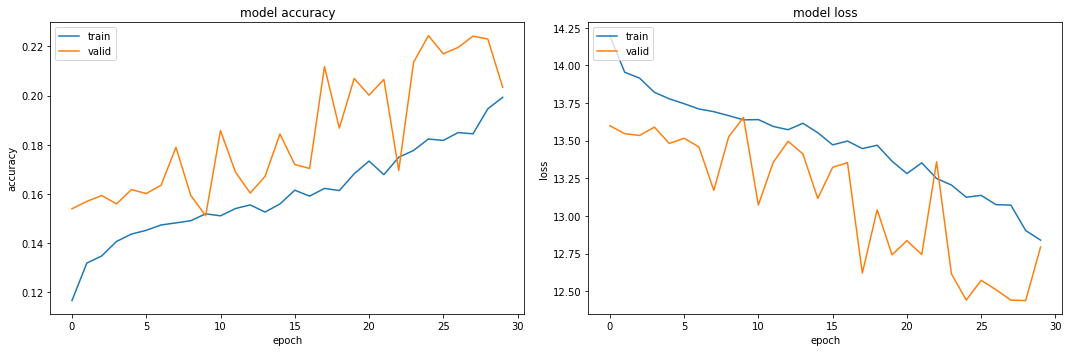

In [53]:
plot_history_curves(history1)

In [54]:
test_loss1, test_acc1 = model1.evaluate(x_test, y_test_one_hot, batch_size=batch_size)
print('test acc1:', test_acc1)

 9740/10000 [============================>.] - ETA: 0stest acc1: 0.202300004303


## Model 2: Use conv classifier

In [9]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train_orig.shape[1:], activation='relu'))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),  loss='categorical_crossentropy', metrics=['acc'])

history2 = model2.fit(x_train_orig, y_train_one_hot,
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(x_valid_orig, y_valid_one_hot))

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 64s - loss: 6.5400 - acc: 0.1395 - val_loss: 2.0596 - val_acc: 0.2734
Epoch 2/30
45000/45000 [==============================] - 62s - loss: 2.0452 - acc: 0.2414 - val_loss: 1.7808 - val_acc: 0.3822
Epoch 3/30
45000/45000 [==============================] - 62s - loss: 1.8608 - acc: 0.3133 - val_loss: 1.6557 - val_acc: 0.4146
Epoch 4/30
45000/45000 [==============================] - 62s - loss: 1.7345 - acc: 0.3628 - val_loss: 1.5667 - val_acc: 0.4388
Epoch 5/30
45000/45000 [==============================] - 62s - loss: 1.6535 - acc: 0.3965 - val_loss: 1.5002 - val_acc: 0.4666
Epoch 6/30
45000/45000 [==============================] - 62s - loss: 1.5867 - acc: 0.4239 - val_loss: 1.4613 - val_acc: 0.4818
Epoch 7/30
45000/45000 [==============================] - 62s - loss: 1.5395 - acc: 0.4424 - val_loss: 1.4005 - val_acc: 0.5022
Epoch 8/30
45000/45000 [==============================]

In [10]:
#model2.save('vgg16-cifar10-model2.h5')

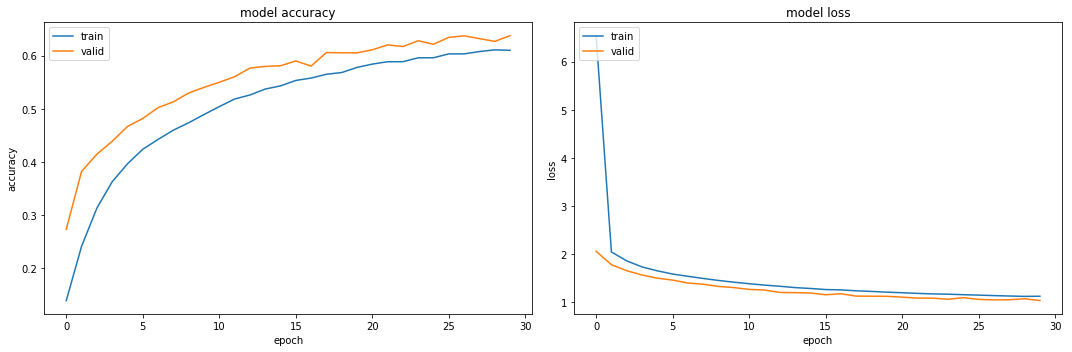

In [11]:
plot_history_curves(history2)

In [47]:
test_loss2, test_acc2 = model2.evaluate(x_test_orig, y_test_one_hot, batch_size=batch_size)
print('test acc2:', test_acc2)

 9960/10000 [============================>.] - ETA: 0stest acc2: 0.641300014496


## Model 3: Use VGG16 - Feature Extraction

In [14]:
from keras.applications import VGG16

# VGG16 - Input size must be at least 48x48;
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
#conv_base.summary()

In [15]:
#Before we compile and train our model, a very important thing to do is to freeze the convolutional base.
conv_base.trainable = False

In [55]:
from keras.preprocessing.image import ImageDataGenerator


# This will do preprocessing and realtime data augmentation:
# train_datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
# train_datagen.fit(x_train_orig)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = train_datagen.flow(x_train_orig, y_train_one_hot, batch_size=batch_size)

# Valid Data Generator
# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow(x_valid_orig, y_valid_one_hot, batch_size=batch_size)

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x_test_orig, y_test_one_hot, batch_size=batch_size)


In [40]:
from keras.backend import tf as ktf


# Create Model3
model3 = models.Sequential()
model3.add(layers.Lambda(lambda image: ktf.image.resize_images(image, (48, 48)), input_shape=(32, 32, 3)))
model3.add(conv_base)

model3.add(layers.Flatten())

model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(num_classes, activation='softmax'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5),  loss='categorical_crossentropy', metrics=['acc'])

steps_per_epoch = x_train_orig.shape[0] // batch_size
print('steps_per_epoch:' + str(steps_per_epoch))
history3 = model3.fit_generator(train_generator, 
                                steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                validation_data=valid_generator, validation_steps=50, 
                                verbose=2)

45000
steps_per_epoch:2250
Epoch 1/30
234s - loss: 2.2832 - acc: 0.1641 - val_loss: 2.0065 - val_acc: 0.3130
Epoch 2/30
235s - loss: 2.0505 - acc: 0.2591 - val_loss: 1.8551 - val_acc: 0.3570
Epoch 3/30
234s - loss: 1.9469 - acc: 0.3049 - val_loss: 1.7552 - val_acc: 0.4160
Epoch 4/30
234s - loss: 1.8812 - acc: 0.3324 - val_loss: 1.6529 - val_acc: 0.4470
Epoch 5/30
234s - loss: 1.8366 - acc: 0.3476 - val_loss: 1.6308 - val_acc: 0.4470
Epoch 6/30
235s - loss: 1.8012 - acc: 0.3625 - val_loss: 1.5677 - val_acc: 0.4610
Epoch 7/30
235s - loss: 1.7843 - acc: 0.3716 - val_loss: 1.5492 - val_acc: 0.4640
Epoch 8/30
235s - loss: 1.7543 - acc: 0.3785 - val_loss: 1.5570 - val_acc: 0.4830
Epoch 9/30
235s - loss: 1.7360 - acc: 0.3875 - val_loss: 1.5534 - val_acc: 0.4580
Epoch 10/30
235s - loss: 1.7184 - acc: 0.3922 - val_loss: 1.4846 - val_acc: 0.4880
Epoch 11/30
235s - loss: 1.7026 - acc: 0.4001 - val_loss: 1.4929 - val_acc: 0.5010
Epoch 12/30
235s - loss: 1.6975 - acc: 0.4028 - val_loss: 1.4550 - va

In [41]:
model3.save('vgg16-cifar10-model3.h5')

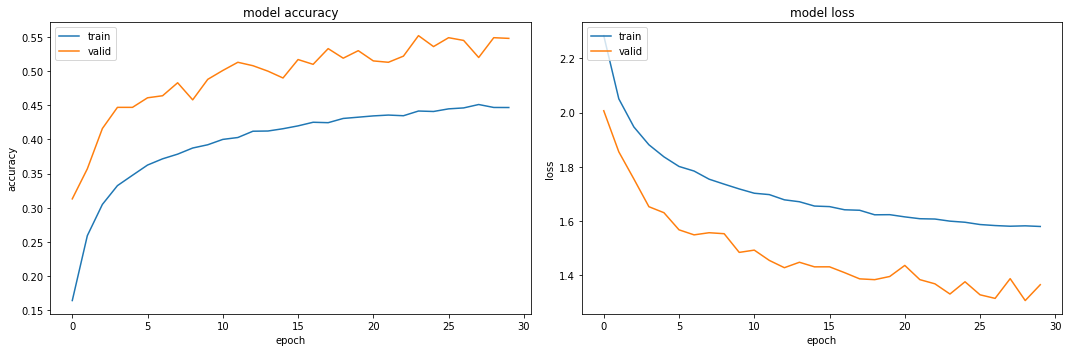

In [42]:
plot_history_curves(history3)

In [44]:
test_loss3, test_acc3 = model3.evaluate_generator(test_generator, steps=x_test_orig.shape[0] // batch_size)
print('test acc3:', test_acc3)

test acc: 0.5317000103


## Model 4: Use VGG16 - Finutuning

In [56]:
# We will fine-tune the last 3 convolutional layers, 
# which means that all layers up until block4_pool should be frozen,
# and the layers  block5_conv1, block5_conv2 and block5_conv3 should be trainable.

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [59]:
# Now we can start fine-tuning our network.
# We will do this with the RMSprop optimizer, using a very low learning rate.
# The reason for using a low learning rate is that we want to limit 
# the magnitude of the modifications we make to the representations of the 3 layers 
# that we are fine-tuning.
# Updates that are too large may harm these representations.
# Now let's proceed with fine-tuning:

from keras.models import load_model
from keras.backend import tf as ktf

model4 = model3#load_model('vgg16-cifar10-model3.h5')
model4.compile(optimizer=optimizers.RMSprop(lr=1e-5),  loss='categorical_crossentropy', metrics=['acc'])

steps_per_epoch = x_train_orig.shape[0] // batch_size
print('steps_per_epoch:' + str(steps_per_epoch))
history4 = model4.fit_generator(train_generator, 
                                steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                validation_data=valid_generator, validation_steps=50, 
                                verbose=2)


steps_per_epoch:2250
Epoch 1/30
514s - loss: 1.3916 - acc: 0.5130 - val_loss: 0.9699 - val_acc: 0.6530
Epoch 2/30
513s - loss: 1.2265 - acc: 0.5725 - val_loss: 0.9673 - val_acc: 0.6510
Epoch 3/30
513s - loss: 1.1533 - acc: 0.5964 - val_loss: 0.8726 - val_acc: 0.6880
Epoch 4/30
513s - loss: 1.1071 - acc: 0.6180 - val_loss: 0.8671 - val_acc: 0.7130
Epoch 5/30
513s - loss: 1.0660 - acc: 0.6316 - val_loss: 0.8089 - val_acc: 0.7300
Epoch 6/30
513s - loss: 1.0429 - acc: 0.6403 - val_loss: 0.8285 - val_acc: 0.7230
Epoch 7/30
513s - loss: 1.0229 - acc: 0.6482 - val_loss: 0.8268 - val_acc: 0.7300
Epoch 8/30
513s - loss: 0.9983 - acc: 0.6560 - val_loss: 0.8106 - val_acc: 0.7210
Epoch 9/30
513s - loss: 0.9875 - acc: 0.6592 - val_loss: 0.8320 - val_acc: 0.7240
Epoch 10/30
513s - loss: 0.9770 - acc: 0.6653 - val_loss: 0.7973 - val_acc: 0.7560
Epoch 11/30
514s - loss: 0.9744 - acc: 0.6694 - val_loss: 0.6760 - val_acc: 0.7720
Epoch 12/30
514s - loss: 0.9648 - acc: 0.6705 - val_loss: 0.7668 - val_acc:

In [60]:
model4.save('vgg16-cifar10-model4.h5')

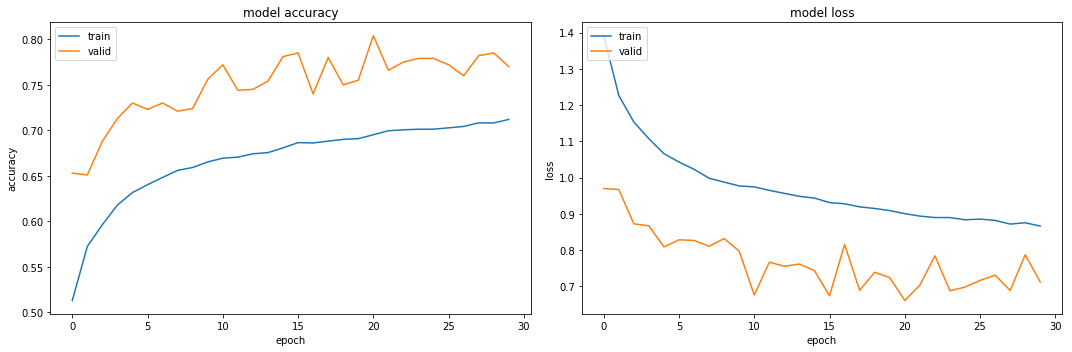

In [61]:
plot_history_curves(history4)

In [62]:
test_loss4, test_acc4 = model4.evaluate_generator(test_generator, steps=x_test_orig.shape[0] // batch_size)
print('test acc4:', test_acc4)

test acc4: 0.771300009847
